# SVI Part I: Stochastic Variational Inference in Pyro

**This Tutorial is adapted from [https://pyro.ai/examples/svi_part_i.html](https://pyro.ai/examples/svi_part_i.html)*

Pyro has been designed with particular attention paid to supporting stochastic variational inference as a general purpose inference algorithm. 

## Setup

We are going to assume we have already defined our model in Pyro. As a quick reminder, the model is given as a stochastic function model(\*args, \**kwargs), which, in the general case takes arguments. 

The different pieces of model() are encoded via the mapping:

1. observations ⟺ **pyro.sample** with the obs argument

2. latent random variables ⟺ **pyro.sample**

3. parameters ⟺ **pyro.param**

Now let's establish some notation. The model has *observations* $\boldsymbol{x}$ and *latent random variables* $\boldsymbol{z}$ as well as parameters $\theta$. It has the joint probability density:

$p_{\theta}(\boldsymbol{x}, \boldsymbol{z}) = p_{\theta}(\boldsymbol{x}\,|\,\boldsymbol{z})\cdot p_{\theta}(\boldsymbol{z})$

We assume that the various probability distributions that make up $p_{\theta}(\boldsymbol{x}, \boldsymbol{z})$ have the following properties:

1. We can sample from each distribution.
2. We can compute the pointwise log pdf of each distribution.
3. Each distribution is differentiable w.r.t. the parameters $\theta$.

## Model Learning

In this context our criterion for learning a good model will be **maximizing the log evidence**, i.e. we want to find the value of $\theta$ given by

$\theta_{max} = \arg \max_{\theta} p_{\theta}(\boldsymbol{x}).$

where the log evidence $\log(p_{\theta}(x))$ is given by

$\log(p_{\theta}(x)) = \log \int \, p_{\theta}(\boldsymbol{x},\boldsymbol{z})\, d\boldsymbol{z}.$

In the general case this is a doubly difficult problem. This is because (even for a fixed $\theta$) the integral over the latent random variables $\boldsymbol{z}$ is often intractable. Furthermore, even if we know how to calculate the log evidence for all values of $\theta$, maximizing the log evidence as a function of $\theta$ will in general be a difficult non-convex optimization problem.

In addition to finding $\theta_{max}$, we would like to calculate the posterior over the latent variables $\boldsymbol{z}$:

$p_{\theta_{max}}(\boldsymbol{z}\,|\,\boldsymbol{x}) = \frac{p_{\theta_{max}}(\boldsymbol{x},\,\boldsymbol{z})}{\int p_{\theta_{max}}(\boldsymbol{x},\,\boldsymbol{z}) d\boldsymbol{z}}$

Note that the denominator of this expression is the (usually intractable) evidence. Variational inference offers a scheme for finding $\theta_{max}$ and computing an approximation to the posterior $p_{\theta_{max}}(\boldsymbol{z}\,|\,\boldsymbol{x})$. Let's see how that works.

## Guide

The basic idea is that we introduce a parameterized distribution $q_{\varphi}(\boldsymbol{z})$, where $\varphi$ are known as the **variational parameters**. This distribution is called the **variational distribution** in much of the literature, and in the context of Pyro it's called **the guide** (Guide = variational distribution). The guide will serve as an approximation to the posterior distribution $p_{\theta_{max}}(\boldsymbol{z}\,|\,\boldsymbol{x})$.

Just like the model, the guide is encoded as a stochastic function **guide()** that contains **pyro.sample** and **pyro.param** statements. It does not contain observed data, since the guide needs to be a properly normalized distribution. Note that Pyro enforces that **model()** and **guide()** have the same call signature, i.e. both callables should take the same arguments.

Since the guide is an approximation to the posterior $p_{\theta_{max}}(\boldsymbol{z}\,|\,\boldsymbol{x})$, the guide needs to provide a valid joint probability density over all the latent random variables in the model. Recall that when random variables are specified in Pyro with the primitive statement **pyro.sample()** the first argument denotes the name of the random variable. These names will be used to align the random variables in the model and guide. 

To be very explicit, if the model contains a random variable $z_1$

In [1]:
def model():
    
    pyro.sample("z_1", ...)

then the guide needs to have a matching sample statement

In [2]:
def guide():
    
    pyro.sample("z_1", ...)

**The distributions used in the two cases can be different, but the names must line-up 1-to-1.**

Once we've specified a guide (we give some explicit examples below), we're ready to proceed to inference. Learning will be setup as an optimization problem where each iteration of training takes a step in $\theta-\varphi$ space that moves the guide closer to the exact posterior. To do this we need to define an appropriate objective function.

## Evidence Lower Bound (ELBO) 

A simple derivation yields what we're after the **evidence lower bound (ELBO)**. The ELBO, which is a function of both $\theta$ and $\varphi$, is defined as an expectation w.r.t. to samples from the guide:

${\rm ELBO} \equiv \mathbb{E}_{q_{\phi}({\bf z})} \left [ \log p_{\theta}({\bf x}, {\bf z}) - \log q_{\phi}({\bf z}) \right]$

By assumption we can compute the log probabilities inside the expectation. And since the guide is assumed to be a parametric distribution we can sample from, we can compute Monte Carlo estimates of this quantity. Crucially, the ELBO is a lower bound to the log evidence, i.e. for all choices of $\theta$ and $\varphi$ we have that

$\log p_{\theta}({\bf x}) \ge {\rm ELBO}$

So if we take (stochastic) gradient steps to maximize the ELBO, we will also be pushing the log evidence higher (in expectation). Furthermore, it can be shown that the gap between the ELBO and the log evidence is given by the KL divergence between the guide and the posterior:

$\log p_{\theta}({\bf x}) - {\rm ELBO} = \rm{KL}\!\left( q_{\phi}({\bf z}) \lVert p_{\theta}({\bf z} | {\bf x}) \right)$

This KL divergence is a particular (non-negative) measure of "closeness" between two distributions. So, for a fixed $\theta$, as we take steps in $\varphi$ space that increase the ELBO, we decrease the KL divergence between the guide and the posterior, i.e. we move the guide towards the posterior. In the general case we take gradient steps in both $\theta$ and $\varphi$ space simultaneously so that the guide and model play chase, with the guide tracking a moving posterior $\log p_{\theta}(\boldsymbol{z}\,|\,\boldsymbol{x})$. Perhaps somewhat surprisingly, despite the moving target, this optimization problem can be solved (to a suitable level of approximation) for many different problems.

So at high level variational inference is easy: all we need to do is **define a guide** and **compute gradients of the ELBO**. Actually, computing gradients for general model and guide pairs leads to some complications (as we will see in the upcoming tutorials). For the purposes of this tutorial, let us consider that a solved problem and look at the support that Pyro provides for doing variational inference.

## SVI Class

In Pyro the machinery for doing variational inference is encapsulated in the **SVI class **. (At present SVI only provides support for the ELBO objective, but in the future Pyro will provide support for alternative variational objectives.)

**The user needs to provide three things**: the *model*, the *guide*, and an *optimizer*. We've discussed the model and guide above and we'll discuss the optimizer in some detail below, so let's assume we have all three ingredients at hand. To construct an instance of SVI that will do optimization via the ELBO objective, we need to write:

In [ ]:
import pyro
from pyro.infer import SVI, Trace_ELBO

svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

The SVI object provides two methods, **step()** and **evaluate_loss()**, that encapsulate the logic for variational learning and evaluation:

1. The method **step()** takes a single gradient step and returns an estimate of the loss (i.e. minus the ELBO). If provided, the arguments to **step()** are piped to **model()** and **guide()**.

2. The method **evaluate_loss()** returns an estimate of the loss without taking a gradient step. Just like for **step()**, if provided, arguments to **evaluate_loss()** are piped to **model()** and **guide()**.

For the case where the loss is the ELBO, both methods also accept an optional argument **num_particles**, which denotes the number of samples used to compute the loss (in the case of evaluate_loss) and the loss and gradient (in the case of step).

## Optimizers

In Pyro, the **model** and **guide** are allowed to be arbitrary stochastic functions provided that:

1. **guide** doesn't contain **pyro.sample** statements with the obs argument.
2. **model** and **guide** have the same call signature.

This presents some challenges because it means that different executions of **model()** and **guide()** may have quite different behavior, with e.g. certain latent random variables and parameters only appearing some of the time. Indeed parameters may be created dynamically during the course of inference. In other words the space we're doing optimization over, which is parameterized by $\theta$ and $\varphi$, can grow and change dynamically.

In order to support this behavior, Pyro needs to dynamically generate an optimizer for each parameter the first time it appears during learning. Luckily, PyTorch has a lightweight optimization library (**torch.optim**) that can easily be repurposed for the dynamic case.

All of this is controlled by the **optim.PyroOptim** class, which is basically a thin wrapper around PyTorch optimizers. PyroOptim takes two arguments: a constructor for PyTorch optimizers **optim_constructor** and a specification of the optimizer arguments **optim_args**. At high level, in the course of optimization, whenever a new parameter is seen **optim_constructor** is used to instantiate a new optimizer of the given type with arguments given by **optim_args**.

Most users will probably not interact with **PyroOptim** directly and will instead interact with the aliases defined in **optim/__init__.py**. Let's see how that goes. There are two ways to specify the optimizer arguments. In the simpler case, **optim_args** is a fixed dictionary that specifies the arguments used to instantiate PyTorch optimizers for all the parameters:

In [4]:
from pyro.optim import Adam

adam_params = {"lr": 0.005, "betas": (0.95, 0.999)}
optimizer   = Adam(adam_params)

The second way to specify the arguments allows for a finer level of control. Here the user must specify a callable that will be invoked by Pyro upon creation of an optimizer for a newly seen parameter. This callable must have the following signature:

1. **module_name**: the Pyro name of the module containing the parameter, if any
2. **param_name**: the Pyro name of the parameter

This gives the user the ability to, for example, customize learning rates for different parameters. For an example where this sort of level of control is useful, see the discussion of baselines. Here's a simple example to illustrate the API:

In [5]:
from pyro.optim import Adam

def per_param_callable(module_name, param_name):
    
    if param_name == 'my_special_parameter':
        
        return {"lr": 0.010}
    
    else:
        
        return {"lr": 0.001}

optimizer = Adam(per_param_callable)

This simply tells Pyro to use a learning rate of 0.010 for the Pyro parameter **my_special_parameter** and a learning rate of 0.001 for all other parameters.

## A simple example

We finish with a simple example. You've been given a two-sided coin. You want to determine whether the coin is fair or not, i.e. whether it falls heads or tails with the same frequency. You have a prior belief about the likely fairness of the coin based on two observations:

- it's a standard quarter issued by the US Mint.
- it's a bit banged up from years of use.

So while you expect the coin to have been quite fair when it was first produced, you allow for its fairness to have since deviated from a perfect 1:1 ratio. So you wouldn't be surprised if it turned out that the coin preferred heads over tails at a ratio of 11:10. By contrast you would be very surprised if it turned out that the coin preferred heads over tails at a ratio of 5:1 — it's not that banged up.

To turn this into a probabilistic model we encode heads and tails as 1's and 0's. We encode the fairness of the coin as a real number $f$, where $f$ satisfies $f \in [0.0, 1.0]$ and $f = \frac{1}{2}$ corresponds to a perfectly fair coin. Our prior belief about $f$ will be encoded by a **beta distribution**, specifically $Beta(10,10)$, which is a symmetric probability distribution on the interval $[0.0, 1.0]$ that is peaked at $f = \frac{1}{2}$.

Let us use what we learned from Tutorial 1 to plot the pdf of a Beta distribution:

c:\users\ahmedmalaa\anaconda3\envs\tensorflow\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


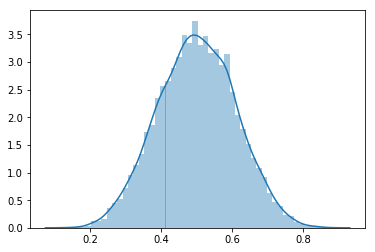

In [11]:
import seaborn as sns
%matplotlib inline

x_points = []

for _ in range(10000):
    
    x_points.append(pyro.distributions.Beta(10,10).sample().numpy())
    
sns.distplot(x_points)    

To learn something about the fairness of the coin that is more precise than our somewhat vague prior, we need to do an experiment and collect some data. Let's say we flip the coin 10 times and record the result of each flip. In practice we'd probably want to do more than 10 trials, but hey this is a tutorial.

Assuming we've collected the data in a list **data**, the corresponding model is given by

In [ ]:
import pyro.distributions as dist

def model(data):
    
    # define the hyperparameters that control the beta prior
    alpha0 = torch.tensor(10.0)
    beta0  = torch.tensor(10.0)
    
    # sample f from the beta prior
    f      = pyro.sample("latent_fairness", dist.Beta(alpha0, beta0))
    
    # loop over the observed data
    for i in range(len(data)):
        # observe datapoint i using the bernoulli
        # likelihood Bernoulli(f)
        pyro.sample("obs_{}".format(i), dist.Bernoulli(f), obs=data[i])

Here we have a single latent random variable (**'latent_fairness'**), which is distributed according to $Beta(10,10)$. Conditioned on that random variable, we observe each of the datapoints using a bernoulli likelihood. Note that each observation is assigned a unique name in Pyro.

Our next task is to define a corresponding guide, i.e. an appropriate variational distribution for the latent random variable $f$. The only real requirement here is that $q(f)$ should be a probability distribution over the range $[0.0,1.0]$, since $f$  doesn't make sense outside of that range. A simple choice is to use another beta distribution parameterized by two trainable parameters $\alpha_q$ and $\beta_q$. Actually, in this particular case this is the "right" choice, since conjugacy of the bernoulli and beta distributions means that the exact posterior is a beta distribution. In Pyro we write:

In [12]:
def guide(data):
    
    # register the two variational parameters with Pyro.
    alpha_q = pyro.param("alpha_q", torch.tensor(15.0),
                         constraint=constraints.positive)
    
    beta_q = pyro.param("beta_q", torch.tensor(15.0),
                        constraint=constraints.positive)
    
    # sample latent_fairness from the distribution Beta(alpha_q, beta_q)
    pyro.sample("latent_fairness", dist.Beta(alpha_q, beta_q))

There are a few things to note here:

- We've taken care that the names of the random variables line up exactly between the model and guide. 

- **model(data)** and **guide(data)** take the same arguments.

- The variational parameters are **torch.tensors**. The **requires_grad** flag is automatically set to True by **pyro.param**.

- We use **constraint=constraints.positive** to ensure that alpha_q and beta_q remain non-negative during optimization.

Now we can proceed to do stochastic variational inference.

In [ ]:
# set up the optimizer
adam_params = {"lr": 0.0005, "betas": (0.90, 0.999)}
optimizer   = Adam(adam_params)

# setup the inference algorithm
svi     = SVI(model, guide, optimizer, loss=Trace_ELBO())

n_steps = 5000

# do gradient steps
for step in range(n_steps):
    svi.step(data)

Note that in the step() method we pass in the data, which then get passed to the model and guide.

The only thing we're missing at this point is some data. So let's create some data and assemble all the code snippets above into a complete script:

In [15]:
from __future__ import print_function
import math
import os
import torch
import torch.distributions.constraints as constraints
import pyro
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
import pyro.distributions as dist

# this is for running the notebook in our testing framework
smoke_test = ('CI' in os.environ)
n_steps    = 2 if smoke_test else 2000

# clear the param store in case we're in a REPL
pyro.clear_param_store()

# create some data with 6 observed heads and 4 observed tails
data = []

for _ in range(6):
    
    data.append(torch.tensor(1.0))

for _ in range(4):
    
    data.append(torch.tensor(0.0))

In [ ]:
def model(data):
    
    # define the hyperparameters that control the beta prior
    alpha0 = torch.tensor(10.0)
    beta0  = torch.tensor(10.0)
    
    # sample f from the beta prior
    f      = pyro.sample("latent_fairness", dist.Beta(alpha0, beta0))
    
    # loop over the observed data
    for i in range(len(data)):
        # observe datapoint i using the bernoulli likelihood
        pyro.sample("obs_{}".format(i), dist.Bernoulli(f), obs=data[i])

def guide(data):
    # register the two variational parameters with Pyro
    # - both parameters will have initial value 15.0.
    # - because we invoke constraints.positive, the optimizer
    # will take gradients on the unconstrained parameters
    # (which are related to the constrained parameters by a log)
    alpha_q = pyro.param("alpha_q", torch.tensor(15.0),
                         constraint=constraints.positive)
    
    beta_q  = pyro.param("beta_q", torch.tensor(15.0),
                         constraint=constraints.positive)
    
    # sample latent_fairness from the distribution Beta(alpha_q, beta_q)
    pyro.sample("latent_fairness", dist.Beta(alpha_q, beta_q))

# setup the optimizer
adam_params = {"lr": 0.0005, "betas": (0.90, 0.999)}
optimizer   = Adam(adam_params)

# setup the inference algorithm
svi         = SVI(model, guide, optimizer, loss=Trace_ELBO())


for step in range(n_steps):
    
    svi.step(data)
    
    if step % 100 == 0:
        print('.', end='')

# grab the learned variational parameters
alpha_q = pyro.param("alpha_q").item()
beta_q  = pyro.param("beta_q").item()

# here we use some facts about the beta distribution
# compute the inferred mean of the coin's fairness
inferred_mean = alpha_q / (alpha_q + beta_q)

# compute inferred standard deviation
factor        = beta_q / (alpha_q * (1.0 + alpha_q + beta_q))
inferred_std  = inferred_mean * math.sqrt(factor)

print("\nbased on the data and our prior belief, the fairness " +
      "of the coin is %.3f +- %.3f" % (inferred_mean, inferred_std))

This estimate is to be compared to the exact posterior mean, which in this case is given by $16/30=0.53$. Note that the final estimate of the fairness of the coin is in between the fairness preferred by the prior (namely $0.50$) and the fairness suggested by the raw empirical frequencies ($6/10=0.60$).